In [37]:
import tensorflow as tf
import numpy as np

# 导入matplotlib
import matplotlib.pyplot as plt

# 导入TF相关模块
from tensorflow.keras import layers, losses, optimizers, Sequential
from tensorflow import keras

# 11. 循环神经网络
卷积神经网络利用数据的局部相关性和权值共享的思想大大减少了网络的参数量，非常适合于图片这种具有空间(Spatial)局部相关性的数据。

自然界的信号除了具有空间维度之外，还有一个时间(Temporal)维度，比如文本、语音信号、股市参数等。这类数据并不一定具有局部相关性，同时数据在时间维度上的长度也是可变的，卷积神经网络并不擅长处理此类数据。

本章介绍的循环神经网络可以较好地解决此类问题。

## 11.1 序列表示方法
具有先后顺序的数据一般叫作`序列`(Sequence)，比如随时间而变化的商品价格数据。考虑某件商品A在1月到6月之间的价格变化趋势，我们记为一维向 量：$[x_1, x_2, x_3, x_4, x_5, x_6]$，它的`shape` 为$[6]$。如果要表示$b$件商品在1月到6月之间的价格变化趋势，可以记为2维张量：
+ $\bigg[\big[x_1^{(1)}, x_2^{(1)}, x_3^{(1)}, x_4^{(1)}, x_5^{(1)}, x_6^{(1)}\big], \big[x_1^{(2)}, x_2^{(2)}, x_3^{(2)}, x_4^{(2)}, x_5^{(2)}, x_6^{(2)}\big],\dots,\big[x_1^{(b)}, x_2^{(b)}, x_3^{(b)}, x_4^{(b)}, x_5^{(b)}, x_6^{(b)}\big]\bigg]$

其中$b$表示商品的数量，张量`shape`为$[b, 6]$。

这么看来，序列信号表示起来并不麻烦，只需要一个`shape`为$[b, s]$的张量即可，其中$b$为序列数量，$s$为序列长度。但是对于很多信号并不能直接用一个标量数值表示，比如每个时间戳产生长度为$n$的特征向量，则需要`shape`为$[b, s, n]$的张量才能表示。

考虑更复杂的文本数据：句子。它在每个时间戳上面产生的单词是一个字符，并不是数值，不能直接用某个标量表示。神经网络不能够直接处理字符串类型的数据，需要把单词用`One-hot`编码。

我们把文字编码为数值的过程叫作`Word Embedding`。`One-hot`编码是最简单的`Word Embedding`实现。但是`One-hot`编码的向量是高维度而且极其稀疏的，计算效率较低，也不利于神经网络的训练。从语义角度来讲，`One-hot`编码忽略了单词先天具有的语义相关性。举个例子，对于单词`like`、`dislike`、`Rome`、`Paris`来说，`like`和`dislike`在语义角度就强相关，它们都表示喜欢的程度；`Rome`和`Paris`同样也是强相关，他们都表示欧洲的两个地点。如果采用`One-hot`编码，得到的向量之间没有相关性，不能很好地体现原有文字的语义相关度。

在自然语言处理领域，有专门的一个研究方向在探索如何学习到`单词表示向量`(Word Vector)，使得语义层面的相关性能够很好地通过`Word Vector`体现出来。一个衡量词向量之间相关度的方法就是`余弦相关度`(Cosine similarity)：
+ $\text{similarity}(a,b) \triangleq \cos(\theta) = \displaystyle\frac{a\cdot b}{\lvert a\rvert \cdot \lvert b\rvert}$

其中$a$和$b$代表了两个词向量。`图11.2`演示了单词`France`和`Italy`的相似度，以及单词`ball`和`crocodile`的相似度，可以看到$\cos(\theta)$较好地反映了语义相关性：

<img src="images/11_02.png" style="width:400px;"/>

### 11.1.1 Embedding层
在神经网络中，单词的表示向量可以直接通过训练的方式得到，我们把单词的表示层叫作`Embedding`层。`Embedding`层负责把单词编码为某个词向量。

`Embedding`层是可训练的，它可放置在神经网络之前，完成单词到向量的转换，得到的表示向量可以继续通过神经网络完成后续任务，并计算误差$\mathcal{L}$，采用梯度下降算法来实现端到端(end-to-end)的训练。

`TensorFlow`通过`layers.Embedding()`来定义一个`Word Embedding`层：

In [2]:
# 生成10个单词的数字编码
x = tf.range(10)
# 打散
x = tf.random.shuffle(x) 
# 创建共10个单词，每个单词用长度为4的向量表示的层
net = layers.Embedding(10, 4)
# 获取词向量
out = net(x) 

上述代码创建了10个单词的`Embedding`层，每个单词用长度为4的向量表示，可以传入数字编码为`0~9`的输入，得到这4个单词的词向量，这些词向量随机初始化的，尚未经过网络训练：

In [3]:
out

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[ 4.0214393e-02, -2.1967782e-02,  4.7393624e-02,  1.1110533e-02],
       [ 3.2366402e-03, -4.1588463e-02,  2.5682036e-02,  4.9591590e-02],
       [ 3.2644879e-02, -4.7255468e-02,  4.3391395e-02,  3.0693617e-02],
       [-2.1821786e-02,  2.1909241e-02, -4.8692118e-02, -6.8046153e-05],
       [-3.2328416e-02,  4.5001898e-02, -1.7626155e-02,  3.7249122e-02],
       [-1.2579404e-02,  1.7369416e-02, -4.5394577e-02,  1.6924527e-02],
       [-4.6396293e-02,  3.6551487e-02,  5.2402169e-04,  1.7208304e-02],
       [ 3.2751810e-02, -2.5065685e-02,  1.8287633e-02,  3.9330218e-02],
       [-4.8573472e-02, -4.1269995e-02, -9.4405413e-03, -8.4045902e-03],
       [-3.2385278e-02, -3.4621287e-02,  1.2773860e-02,  7.4205399e-03]],
      dtype=float32)>

我们可以直接查看`Embedding`层内部的查询表`table`。可以看到`net.embeddings`张量的可优化属性为`True`，即可以通过梯度下降算法优化。

In [4]:
net.embeddings

<tf.Variable 'embedding/embeddings:0' shape=(10, 4) dtype=float32, numpy=
array([[ 3.2644879e-02, -4.7255468e-02,  4.3391395e-02,  3.0693617e-02],
       [-4.8573472e-02, -4.1269995e-02, -9.4405413e-03, -8.4045902e-03],
       [-3.2328416e-02,  4.5001898e-02, -1.7626155e-02,  3.7249122e-02],
       [-4.6396293e-02,  3.6551487e-02,  5.2402169e-04,  1.7208304e-02],
       [-1.2579404e-02,  1.7369416e-02, -4.5394577e-02,  1.6924527e-02],
       [ 3.2751810e-02, -2.5065685e-02,  1.8287633e-02,  3.9330218e-02],
       [ 4.0214393e-02, -2.1967782e-02,  4.7393624e-02,  1.1110533e-02],
       [ 3.2366402e-03, -4.1588463e-02,  2.5682036e-02,  4.9591590e-02],
       [-2.1821786e-02,  2.1909241e-02, -4.8692118e-02, -6.8046153e-05],
       [-3.2385278e-02, -3.4621287e-02,  1.2773860e-02,  7.4205399e-03]],
      dtype=float32)>

### 11.1.2 预训练的词向量
`Embedding`层的查询表是随机初始化的，需要从零开始训练。实际上，我们可以使用预训练的`Word Embedding`模型来得到单词的表示方法，基于预训练模型的词向量相当于迁移了整个语义空间的知识，往往能得到更好的性能。

目前应用的比较广泛的预训练模型有`Word2Vec`和`GloVe`等，它们已经在海量语料库训练得到了较好的词向量表示方法。比如`GloVe`模型`GloVe.6B.50d`，词汇量为40万，每个单词使用长度为50的向量表示。

那么如何使用这些预训练的词向量模型来帮助提升`NLP`任务的性能？非常简单，对于`Embedding`层，不再采用随机初始化的方式，而是利用我们已经预训练好的模型参数去初始化`Embedding`层的查询表：

```python
# 从预训练模型中加载词向量表
embed_glove = load_embed('glove.6B.50d.txt')
# 直接利用预训练的词向量表初始化 Embedding 层
net.set_weights([embed_glove])
```

经过预训练的词向量模型初始化的`Embedding`层可以设置为不参与训练：`net.trainable = False`，那么预训练的词向量就直接应用到此特定任务上；如果希望能够学到区别于预训练词向量模型不同的表示方法，那么可以把`Embedding`层包含进反向传播算法中去，利用梯度下降来微调单词表示方法。

## 11.2 循环神经网络
以文本序列为例：
> “I hate this boring movie”

通过`Embedding`层，可以将它转换为`shape`为$[b,s,n]$的张量，$b$为句子数量，$s$为句子长度，$n$为词向量长度。上述句子可以表示为`shape`为$[1,5,10]$的张量。

我们以情感分类任务为例逐步探索能够处理序列信号的网络模型，如`图11.3`所示。

<img src="images/11_03.png" style="width:450px;"/>

情感分类任务通过分析给出的文本序列，提炼出文本数据表达的整体语义特征，从而预测输入文本的情感类型：正面评价或者负面评价。

### 11.2.1 全连接层可行吗
首先我们想到的是，对于每个词向量，分别使用一个全连接层网络：
+ $o = \sigma(W_tx_t+b_t)$

提取语义特征，如`图11.4`所示，各个单词的词向量通过$s$个全连接层`分类网络1`提取每个单词的特征，所有单词的特征最后合并，并通过`分类网络2`输出序列的类别概率分布，对于长度为$s$的句子来说，至少需要$s$个全网络层。

<img src="images/11_04.png" style="width:500px;"/>

这种方案的缺点有：
+ 网络参数量是相当可观的，内存占用和计算代价较高，同时由于每个序列的长度$s$并不相同，网络结构是动态变化的
+ 每个全连接层子网络$W_i$和$b_i$只能感受当前词向量的输入，并不能感知之前和之后的语境信息，导致句子整体语义的缺失，每个子网络只能根据自己的输入来提取高层特征，有如管中窥豹

我们接下来逐一解决这2大缺陷。

### 11.2.2 共享权值
卷积神经网络之所以在处理局部相关数据时优于全连接网络，是因为它充分利用了权值共享的思想，大大减少了网络的参数量。我们在处理序列信号时能否借鉴权值共享的思想呢？

`图11.4`中的方案，$s$个全连接层的网络并没有实现权值同享。我们尝试将这$s$个网络层参数共享，这样其实相当于使用一个全连接网络来提取所有单词的特征信息，如`图11.5`所示。

<img src="images/11_05.png" style="width:500px;"/>

通过权值共享后，参数量大大减少。但是，这种网络结构也没有考虑序列之间的先后顺序，将词向量打乱次序仍然能获得相同的输出，无法获取有效的全局语义信息。

### 11.2.3 全局语义
如何赋予网络提取整体语义特征的能力呢？我们想到了内存(Memory)机制。如果网络能够提供一个单独的内存变量，每次提取词向量的特征并刷新内存变量，直至最后一个输入完成，此时的内存变量即存储了所有序列的语义特征，并且由于输入序列之间的先后顺序，使得内存变量内容与序列顺序紧密关联。

<img src="images/11_06.png" style="width:500px;"/>

我们将上述`Memory`机制实现为一个状态张量 ，如`图11.6`所示，除了原来的$W_{x,h}$参数共享外，这里额外增加了一个$W_{hh}$参数，每个时间戳$t$上状态张量$h$刷新机制为：
+ $h_t = \sigma(W_{xh}x_t + W_{hh}h_{t−1} + b)$

其中状态张量$h_0$为初始的内存状态，可以初始化为全0，经过$s$个词向量的输入后得到网络最终的状态张量$h_s$，$h_s$较好地代表了句子的全局语义信息，基于$h_s$通过某个全连接层分类器即可完成情感分类任务。

### 11.2.4 循环神经网络
通过一步步地探索，我们最终提出了一种如`图11.7`所示的网络模型：

<img src="images/11_07.png" style="width:400px;"/>

在每个时间戳$t$，网络层接受当前时间戳的输入$x_t$和上一个时间戳的网络状态向量$h_{t-1}$，经过$h_t = f_{\theta}(h_{t−1}, x_t)$

变换后得到当前时间戳的新状态向量$h_t$，并写入内存状态中，其中$f_{\theta}$代表了网络的运算逻辑，$\theta$为网络参数集。在每个时间戳上，网络层均有输出产生$o_t$，$o_t = g_{\phi}(h_t)$，即将网络的状态向量变换后输出。

上述网络结构在时间戳上折叠，如`图11.8`所示，网络循环接受序列的每个特征向量$x_t$，并刷新内部状态向量$t$，同时形成输出$o_t$。对于这种网络结构，我们把它叫做`循环网络结构`(Recurrent Neural Network，简称 RNN)。

<img src="images/11_08.png" style="width:200px;"/>

更特别地，如果使用张量$W_{xh}$、$W_{hh}$和偏置$b$来参数化$f_{\theta}$网络，并按照$h_t = \sigma(W_{xh}x_t + W_{hh}h_{t−1} + b)$方式更新内存状态，我们把这种网络叫做基本的循环神经网络。

在循环神经网络中，激活函数更多地采用`tanh`函数，并且可以选择不使用偏置$b$来进一步减少参数量。状态向量$h_t$可以直接用作输出，即$o_t=h_t$，也可以对$h_t$做一个简单的线性变换$o_t = W_{ho}h_t$后得到每个时间戳上的网络输出$o_t$。

## 11.3 梯度传播
通过循环神经网络的更新表达式可以看出输出对张量$W_{xh}、W_{hh}$和偏置$b$均是可导的，可以利用自动梯度算法来求解网络的梯度。此处我们仅简单地推导一下RNN的梯度传播公式，并观察其特点。

考虑梯度$\displaystyle\frac{\partial\mathcal{L}}{\partial W_{hh}}$，其中$\mathcal{L}$为网络的误差，只考虑最后一个时刻$t$的输出$o_t$与真实值之间的差距。由于$W_{hh}$被每个时间戳$i$上权值共享，在计算$\displaystyle\frac{\partial\mathcal{L}}{\partial W_{hh}}$时需要将每个中间时间戳$i$上面的梯度求和，利用链式法则展开为
+ $\displaystyle\frac{\partial\mathcal{L}}{\partial W_{hh}}=\sum_{i=1}^{t}\frac{\partial\mathcal{L}}{\partial o_t}\frac{\partial o_t}{\partial h_t}\frac{\partial h_t}{\partial h_i}\frac{\partial^+ h_i}{\partial W_{hh}}$

其中$\displaystyle\frac{\partial\mathcal{L}}{\partial o_t}$可以基于损失函数直接求得，$\displaystyle\frac{\partial o_t}{\partial h_t}$在$o_t=h_t$的情况下：
+ $\displaystyle\frac{\partial o_t}{\partial h_t} = 1$

而$\displaystyle\frac{\partial^+ h_i}{\partial W_{hh}}$的梯度将$h_i$展开后也可以求得：
+ $\displaystyle\frac{\partial^+ h_i}{\partial W_{hh}} = \frac{\partial\sigma\big(W_{xh}x_t+W_{hh}h_{t-1}+b\big)}{\partial W_{hh}}$

其中$\displaystyle\frac{\partial^+ h_i}{\partial W_{hh}}$只考虑到一个时间戳的梯度传播，即`直接`偏导数，与$\displaystyle\frac{\partial\mathcal{L}}{\partial W_{hh}}$考虑$i=1,\dots,t$所有的时间戳的偏导数不同。

因此，只需要推导出$\displaystyle\frac{\partial h_t}{\partial h_i}$的表达式即可完成循环神经网络的梯度推导。利用链式法则，我们把$\displaystyle\frac{\partial h_t}{\partial h_i}$分拆分连续时间戳的梯度表达式：
+ $\displaystyle\frac{\partial h_t}{\partial h_i} = \frac{\partial h_t}{\partial h_{t-1}}\frac{\partial h_{t-1}}{\partial h_{t-2}}\dots\frac{\partial h_{i+1}}{\partial h_i} = \prod_{k=1}^{t-1}\frac{\partial h_{k+1}}{\partial h_{k}}$

考虑到
+ $h_{k+1} = \sigma\big(W_{xh}x_{k+1}+W_{hh}h_k+b\big)$

那么
+ $\displaystyle\frac{\partial h_{k+1}}{\partial h_{k}} = W_{hh}^{T}\mathit{diag}\bigg(\sigma'\big(W_{xh}x_{k+1}+W_{hh}h_k+b\big)\bigg) = W_{hh}^{T}\mathit{diag}\bigg(\sigma'\big(h_{k+1}\big)\bigg)$

其中$\mathit{diag}(x)$是把向量$x$的每个元素作为矩阵的对角元素的对角矩阵， 例如：
+ $\mathit{diag} = \begin{bmatrix}3&0&0\\0&2&0\\0&0&1\\ \end{bmatrix}$

因此
+ $\displaystyle\frac{\partial h_t}{\partial h_i} = \prod_{j=i}^{t-1}\mathit{diag}\bigg(\sigma'\big(W_{xh}x_{j+1}+W_{hh}h_j+b\big)\bigg)W_{hh}$

至此，$\displaystyle\frac{\partial\mathcal{L}}{\partial W_{hh}}$的梯度推导完成。

由于深度学习框架可以帮助我们自动推导梯度，只需要简单地了解循环神经网络的梯度传播方式即可。我们在推导$\displaystyle\frac{\partial\mathcal{L}}{\partial W_{hh}}$的过程中发现，$\displaystyle\frac{\partial h_t}{\partial h_i}$的梯度包含了$W_{hh}$的连乘运算，我们会在后面介绍，这是导致循环神经网络训练困难的根本原因。

## 11.4 RNN 层使用方法
`TensorFlow`通过`layers.SimpleRNNCell`实现基础循环神经网络。`SimpleRNN`与`SimpleRNNCell`的区别在于，带`Cell`的层仅仅是完成了一个时间戳的前向运算，不带`Cell`的层一般是基于`Cell`层实现的，它在内部已经完成了多个时间戳的循环运算，因此使用起来更为方便快捷。

### 11.4.1 SimpleRNNCell
以某输入特征长度$n=4$，`Cell`状态向量特征长度$h = 3$为例，首先我们新建一个`SimpleRNNCell`，不需要指定序列长度$s$：

In [5]:
# 创建RNN Cell，内存向量长度为 3
cell = layers.SimpleRNNCell(3)
# 输出特征长度n=4
cell.build(input_shape=(None,4)) 
# 打印W_xh, W_hh, b张量
for v in cell.trainable_variables:
    print("name: {}, shape: {}, type: {}".format(v.name, v.shape, v.dtype))

name: kernel:0, shape: (4, 3), type: <dtype: 'float32'>
name: recurrent_kernel:0, shape: (3, 3), type: <dtype: 'float32'>
name: bias:0, shape: (3,), type: <dtype: 'float32'>


`SimpleRNNCell`内部维护了3个张量，`kernel`变量即$W_{xh}$张量，`recurrent_kernel`变量即$W_{hh}$张量，`bias`变量即偏置$b$向量。但是RNN的`Memory`向量并不由`SimpleRNNCell`维护，需要用户自行初始化向量$h_0$并记录每个时间戳上的$t$。

通过调用`Cell`实例即可完成前向运算：
+ $o_t,[h_t] = \text{Cell}(x_t, [h_{t-1}])$

对于`SimpleRNNCell`来说，$o_t=h_t$，并没有经过额外的线性层转换，是同一个对象；$[h_t]$通过一个`List`包裹起来，这么设置是为了与`LSTM`、`GRU`等RNN变种格式统一。在循环神经网络的初始化阶段，状态向量$h_0$一般初始化为全0向量：

In [6]:
# 初始化状态向量，用列表包裹，统一格式
h0 = [tf.zeros([4, 64])]
# 生成输入张量，4个80单词的句子
x = tf.random.normal([4, 80, 100]) 
# 所有句子的第1个单词
xt = x[:,0,:] 
# 构建输入特征n=100,序列长度s=80,状态长度=64的Cell
cell = layers.SimpleRNNCell(64)
# 前向计算
out, h1 = cell(xt, h0) 
out.shape, h1[0].shape

(TensorShape([4, 64]), TensorShape([4, 64]))

可以看到经过一个时间戳的计算后，输出和状态张量的`shape`都为$[b,h]$，打印出这两者的`id`如下：

In [7]:
id(out), id(h1[0])

(139687642413096, 139687642413096)

两者`id`一致，即状态向量直接作为输出向量。对于长度为$s$的训练来说，需要循环通过`Cell`类$s$次才算完成一次网络层的前向运算：

In [8]:
# h保存每个时间戳上的状态向量列表
h = h0

# 在序列长度的维度解开输入，得到xt:[b,n]
for xt in tf.unstack(x, axis=1):
    # 前向计算,out和h均被覆盖
    out, h = cell(xt, h) 

# 最终输出可以聚合每个时间戳上的输出，也可以只取最后时间戳的输出
out = out
out.shape

TensorShape([4, 64])

最后一个时间戳的输出变量`out`将作为网络的最终输出。实际上，也可以将每个时间戳上的输出保存，然后求和或者均值，将其作为网络的最终输出。

### 11.4.2 多层SimpleRNNCell网络
和卷积神经网络一样，循环神经网络虽然在时间轴上面展开了多次，但只能算一个网络层。通过在深度方向堆叠多个`Cell`类来实现深层卷积神经网络一样的效果，大大的提升网络的表达能力。但是和卷积神经网络动辄几十、上百的深度层数来比，循环神经网络很容易出现`梯度弥散`和`梯度爆炸`现象，深层的循环神经网络训练起来非常困难，目前常见的循环神经网络模型层数一般控制在十层以内。

我们这里以两层的循环神经网络为例，介绍利用`Cell`方式构建多层RNN网络：

In [9]:
x = tf.random.normal([4,80,100])
# 取第一个时间戳的输入x0
xt = x[:,0,:] 
# 构建2个Cell, 内存状态向量长度都为64
cell0 = layers.SimpleRNNCell(64)
cell1 = layers.SimpleRNNCell(64)
# cell0的初始状态向量
h0 = [tf.zeros([4,64])] 
# cell1的初始状态向量
h1 = [tf.zeros([4,64])] 

在时间轴上面循环计算多次来实现整个网络的前向运算，每个时间戳上的输入`xt`首先通过第一层，得到输出`out0`，再通过第二层，得到输出`out1`：

In [10]:
for xt in tf.unstack(x, axis=1):
    # xtw作为输入，输出为out0
    out0, h0 = cell0(xt, h0)
    # 上一个cell的输出out0作为本cell的输入
    out1, h1 = cell1(out0, h1)

上述方式先完成一个时间戳上的输入在所有层上的传播，再循环计算完所有时间戳上的输 入。

实际上，也可以先完成输入在第一层上所有时间戳的计算，并保存第一层在所有时间戳上的输出列表，再计算第二层、第三层等的传播：

In [11]:
# 保存上一层的所有时间戳上面的输出
middle_sequences = []
# 计算第一层的所有时间戳上的输出，并保存
for xt in tf.unstack(x, axis=1):
    out0, h0 = cell0(xt, h0)
    middle_sequences.append(out0)
# 计算第二层的所有时间戳上的输出
# 如果不是末层，需要保存所有时间戳上面的输出
for xt in middle_sequences:
    out1, h1 = cell1(xt, h1)

使用这种方式的话，我们需要一个额外的`List`来保存上一层所有时间戳上面的状态信息。这两种方式效果相同，可以根据个人喜好选择编程风格。

需要注意的是，循环神经网络的每一层、每一个时间戳上面均有状态输出，那么对于后续任务来说，我们应该收集哪些状态输出最有效呢？一般来说，最末层 `Cell`的状态有可能保存了高层的全局语义特征，因此一般使用最末层的输出作为后续任务网络的输入。更特别地，每层最后一个时间戳上的状态输出包含了整个序列的全局信息，如果只希望选用一个状态变量来完成后续任务，比如情感分类问题，一般选用最末层、最末时间戳的状态输出最为合适。

### 11.4.3 SimpleRNN层
通过`SimpleRNNCell`层的使用可以非常深入地理解循环神经网络前向运算的每个细节。在实际使用中，为了简便，通常使用`SimpleRNN`高层接口。

In [12]:
# 创建状态向量长度为64的SimpleRNN层
layer = layers.SimpleRNN(64) 
x = tf.random.normal([4, 80, 100])
# 和普通卷积网络一样，一行代码即可获得输出
out = layer(x)
out.shape

TensorShape([4, 64])

`SimpleRNN`仅需一行代码即可完成整个前向运算过程，它默认返回最后一个时间戳上的输出。

如果希望返回所有时间戳上的输出列表，可以设置`return_sequences=True`参数：

In [13]:
# 创建RNN层时，设置返回所有时间戳上的输出
layer = layers.SimpleRNN(64,return_sequences=True)
# 前向计算
out = layer(x) 
# 输出，自动进行了concat操作
x.shape, out.shape

(TensorShape([4, 80, 100]), TensorShape([4, 80, 64]))

输出张量`shape`为$[4,80,64]$，中间维度的80即为时间戳维度。

可以通过堆叠多个`SimpleRNN`实现多层循环神经网络：

In [14]:
net = keras.Sequential([ 
    # 构建2层RNN网络，除最末层外，都需要返回所有时间戳的输出，用作下一层的输入
    layers.SimpleRNN(64, return_sequences=True),
    layers.SimpleRNN(64),
])

# 前向计算
out = net(x) 
out.shape

TensorShape([4, 64])

## 11.5 RNN情感分类问题实战
现在利用基础的RNN网络来解决情感分类问题。网络结构如`图11.9`所示，RNN网络共两层，循环提取序列信号的语义特征，利用第2层RNN层的最后时间戳的状态向量$h_s^{2}$作为句子的全局语义特征表示，送入全连接层构成的分类网络3，得到样本$x$为积极情感的概率$P(x为积极情感|x)\in[0,1]$。

<img src="images/11_09.png" style="width:500px;"/>

### 11.5.1 数据集
我们使用经典的`IMDB`影评数据集。`IMDB`影评数据集包含了50000条用户评价，评价的标签分为消极和积极，其中`IMDB`评级$\lt5$的用户评价标注为0，即消极；`IMDB`评价$\ge7$的用户评价标注为1，即积极。25000条影评用于训练集，25000条用于测试集。

In [15]:
# 批量大小
batchsz = 128 
# 词汇表大小N_vocab
total_words = 10000 
# 句子最大长度s，大于的句子部分将截断，小于的将填充
max_review_len = 80 
# 词向量特征长度n
embedding_len = 100 
# 加载IMDB数据集，此处的数据采用数字编码，一个数字代表一个单词
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=total_words)

# 打印输入的形状，标签的形状
print(x_train.shape, len(x_train[0]), y_train.shape)
print(x_test.shape, len(x_test[0]), y_test.shape)

(25000,) 218 (25000,)
(25000,) 68 (25000,)


可以看到，`x_train`和`x_test`是长度为25000的一维数组，数组的每个元素是不定长`List`，保存了数字编码的每个句子，例如训练集的第一个句子共有218个单词，测试集的第一个句子共有68个单词，每个句子都包含了句子起始标志ID。

那么每个单词是如何编码为数字的呢？我们可以通过查看它的编码表获得编码方案：

In [16]:
word_index = keras.datasets.imdb.get_word_index()
# 打印出编码表的单词和对应的数字
i = 0
for k,v in word_index.items():
    print(k,v)
    i += 1
    if i >10:
        break

fawn 34701
tsukino 52006
nunnery 52007
sonja 16816
vani 63951
woods 1408
spiders 16115
hanging 2345
woody 2289
trawling 52008
hold's 52009


由于编码表的键为单词，值为ID，这里翻转编码表，并添加标志位的编码ID，代码如下：

In [17]:
# 前面4个ID是特殊位
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
# 填充标志
word_index["<START>"] = 1 # 起始标志
word_index["<UNK>"] = 2
# 未知单词的标志
word_index["<UNUSED>"] = 3
# 翻转编码表
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

对于一个数字编码的句子，通过如下函数转换为字符串数据：

In [18]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(x_train[1])

"<START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal <UNK> the hair is big lots of boobs <UNK> men wear those cut <UNK> shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

对于长度参差不齐的句子，人为设置一个阈值，对大于此长度的句子，选择截断部分单词，可以选择截去句首单词，也可以截去句末单词；对于小于此长度的句子，可以选择在句首或句尾填充。

句子截断功能通过`keras.preprocessing.sequence.pad_sequences()`函数实现：

In [19]:
# 截断和填充句子，使得等长，此处长句子保留句子后面的部分，短句子在前面填充
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_review_len)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_review_len)

截断或填充为相同长度后，通过`Dataset`类包裹成数据集对象，并添加常用的数据集处理流程：

In [20]:
# 构建数据集、打散、批量，并丢掉最后一个不够batchsz的batch
db_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# drop_remainder=True丢弃掉最后一个Batch，因为真实的Batch Size可能小于预设的Batch Size
db_train = db_train.shuffle(1000).batch(batchsz, drop_remainder=True)
db_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
db_test = db_test.batch(batchsz, drop_remainder=True)

# 统计数据集属性
print('x_train shape:', x_train.shape, tf.reduce_max(y_train), tf.reduce_min(y_train))
print('x_test shape:', x_test.shape)

x_train shape: (25000, 80) tf.Tensor(1, shape=(), dtype=int64) tf.Tensor(0, shape=(), dtype=int64)
x_test shape: (25000, 80)


### 11.5.2 网络模型
自定义的模型类`MyRNN`，包含一个`Embedding`层、两个`RNN`层、以及分类网络层：

In [29]:
class MyRNN(keras.Model):
    # Cell方式构建多层网络
    def __init__(self, units):
        super(MyRNN, self).__init__() 
        # 词向量编码 [b, 80] => [b, 80, 100]
        self.embedding = layers.Embedding(total_words, embedding_len,
                                          input_length=max_review_len)
        # 构建RNN
        self.rnn = keras.Sequential([
            layers.SimpleRNN(units, dropout=0.5, return_sequences=True),
            layers.SimpleRNN(units, dropout=0.5)
        ])
        # 构建分类网络，用于将CELL的输出特征进行分类，2分类
        # [b, 80, 100] => [b, 64] => [b, 1]
        self.outlayer = Sequential([
        	layers.Dense(32),
        	layers.Dropout(rate=0.5),
        	layers.ReLU(),
        	layers.Dense(1)])

    def call(self, inputs, training=None):
        x = inputs # [b, 80]
        # embedding: [b, 80] => [b, 80, 100]
        x = self.embedding(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        x = self.rnn(x)
        # 末层最后一个输出作为分类网络的输入: [b, 64] => [b, 1]
        x = self.outlayer(x,training)
        # p(y is pos|x)
        prob = tf.sigmoid(x)

        return prob

### 11.5.3 训练与测试
设置优化器为`Adam`优化器，学习率为0.001，误差函数选用二分类的交叉熵损失函数 BinaryCrossentropy，测试指标采用准确率即可：

In [30]:
def main():
    units = 64 # RNN状态向量长度
    epochs = 20 # 训练epochs
    model = MyRNN(units) # 创建模型
    # 装配
    model.compile(optimizer = optimizers.Adam(0.001), loss = losses.BinaryCrossentropy(), metrics=['accuracy'])
    # 训练和验证
    model.fit(db_train, epochs=epochs, validation_data=db_test)
    # 测试
    model.evaluate(db_test)

main()

Train for 195 steps, validate for 195 steps
Epoch 1/20
195/195 [==============================] - 17s 87ms/step - loss: 0.6994 - accuracy: 0.5058 - val_loss: 0.6923 - val_accuracy: 0.5096
Epoch 2/20
195/195 [==============================] - 15s 76ms/step - loss: 0.6833 - accuracy: 0.5471 - val_loss: 0.6489 - val_accuracy: 0.6398
Epoch 3/20
195/195 [==============================] - 15s 76ms/step - loss: 0.5345 - accuracy: 0.7430 - val_loss: 0.4364 - val_accuracy: 0.8020
Epoch 4/20
195/195 [==============================] - 15s 78ms/step - loss: 0.3805 - accuracy: 0.8451 - val_loss: 0.4265 - val_accuracy: 0.8207
Epoch 5/20
195/195 [==============================] - 15s 76ms/step - loss: 0.3171 - accuracy: 0.8761 - val_loss: 0.4370 - val_accuracy: 0.8314
Epoch 6/20
195/195 [==============================] - 15s 75ms/step - loss: 0.2548 - accuracy: 0.9044 - val_loss: 0.4780 - val_accuracy: 0.8225
Epoch 7/20
195/195 [==============================] - 15s 75ms/step - loss: 0.2016 - accurac

## 11.6 梯度弥散和梯度爆炸
循环神经网络的训练并不稳定，网络的深度也不能任意的加深。那么，为什么循环神经网络会出现训练困难的问题呢？简单回顾梯度推导中的关键表达式：
+ $\displaystyle\frac{\partial h_t}{\partial h_i} = \prod_{j=i}^{t-1}\mathit{diag}\bigg(\sigma'\big(W_{xh}x_{j+1}+W_{hh}h_j+b\big)\bigg)W_{hh}$

也就是说，从时间戳$i$到时间戳$t$的梯度$\displaystyle\frac{\partial h_t}{\partial h_i}$包含了$W_{hh}$的连乘运算。当$W_{hh}$的最大特征值(Largest Eignvalue)小于1时，多次连乘运算会使得$\displaystyle\frac{\partial h_t}{\partial h_i}$的元素值接近于零；当$\displaystyle\frac{\partial h_t}{\partial h_i}$的值大于1时，多次连乘运算会使得$\displaystyle\frac{\partial h_t}{\partial h_i}$的元素值爆炸式增长。

我们可以从下面的两个例子直观地感受一下梯度弥散和梯度爆炸现象的产生：

In [34]:
# 任意创建某矩阵
W = tf.ones([2,2])
# 计算矩阵的特征值
eigenvalues = tf.linalg.eigh(W)[0]
eigenvalues

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.       , 1.9999999], dtype=float32)>

可以看到，全1矩阵的最大特征值为2。计算$W$矩阵的$W^1 \sim W^{10}$运算结果，并绘制为次方与矩阵的`L2`范数的曲线图，可以看到，当$W$矩阵的最大特征值大于1时，矩阵多次相乘会使得结果越来越大。

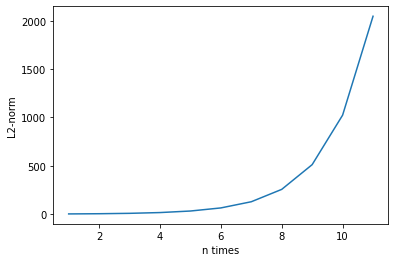

In [38]:
val = [W]
# 矩阵相乘n次方
for i in range(10): 
    val.append([val[-1]@W])
    
# 计算L2范数
norm = list(map(lambda x:tf.norm(x).numpy(),val))

# 绘图
plt.plot(range(1,12), norm)
plt.xlabel('n times')
plt.ylabel('L2-norm')
plt.show()

当最大特征值小于1时：

tf.Tensor([0.         0.79999995], shape=(2,), dtype=float32)


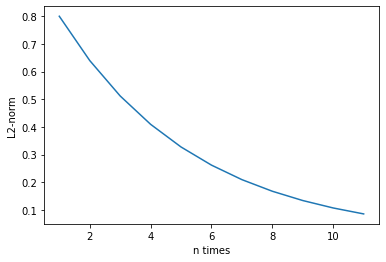

In [40]:
# 任意创建某矩阵
W = tf.ones([2,2])*0.4 
eigenvalues = tf.linalg.eigh(W)[0]
print(eigenvalues)

val = [W]
for i in range(10):
    val.append([val[-1]@W])

# 计算L2范数
norm = list(map(lambda x:tf.norm(x).numpy(),val))

# 绘图
plt.plot(range(1,12), norm)
plt.xlabel('n times')
plt.ylabel('L2-norm')
plt.show()

我们把梯度值接近于0的现象叫做`梯度弥散`(Gradient Vanishing)，把梯度值远大于1的现象叫做`梯度爆炸`(Gradient Exploding)。

考虑梯度下降算法：
+ $\theta' = \theta - \mu\nabla_{\theta}\mathcal{L}$

+ 当出现梯度弥散时，$\nabla_{\theta}\mathcal{L} \approx 0$，此时$\theta'\approx\theta$，神经网络的参数长时间得不到更新，具体表现为$\mathcal{L}$几乎保持不变
+ 当出现梯度爆炸时，$\nabla_{\theta}\mathcal{L} \gg 1$，此时梯度的更新步长$\theta'\approx\theta$非常大，使得更新后的$\theta'$与$\theta$差距很大，网络$\mathcal{L}$出现突变现象，甚至可能出现来回震荡、不收敛的现象

那么怎么解决这两个问题呢？

### 11.6.1 梯度裁剪
`梯度爆炸`可以通过`梯度裁剪`(Gradient Clipping)的方式在一定程度上的解决。梯度裁剪与张量限幅非常类似，也是通过将梯度张量的数值或者范数限制在某个较小的区间内，从而将远大于1的梯度值减少，避免出现梯度爆炸。

在深度学习中，有3种常用的梯度裁剪方式：

##### 方法1:限幅
对张量的数值进行限幅，使得张量$W$的所有元素$w_{ij} \in [\mathrm{min},\mathrm{max}]$。`TensorFlow`通过`tf.clip_by_value()`函数来实现:

In [42]:
a=tf.random.uniform([2,2])
a, tf.clip_by_value(a,0.4,0.6) 

(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.6676514 , 0.6177614 ],
        [0.41793048, 0.33756483]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.6       , 0.6       ],
        [0.41793048, 0.4       ]], dtype=float32)>)

##### 方法2:限制范数
将$W$的$L2$范数约束在$[0, \mathrm{max}]$之间，如果$L2$范数大于$\mathrm{max}$值，则按照
+ $W'=\displaystyle\frac{W}{\lVert W \rVert_{2}}\cdot\mathrm{max}$

方式将$\lVert W' \rVert_{2}$约束$\mathrm{max}$内。可以通过`tf.clip_by_norm`函数实现：

In [44]:
a=tf.random.uniform([2,2]) * 5
# 按范数方式裁剪
b = tf.clip_by_norm(a, 5)
# 裁剪前和裁剪后的张量范数
tf.norm(a), tf.norm(b)

(<tf.Tensor: shape=(), dtype=float32, numpy=5.5082097>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>)

##### 方法3:全局范数裁剪
神经网络的更新方向是由所有参数的梯度张量$W$共同表示的，前两种方式只考虑单个梯度张量的限幅，会出现网络更新方向发生变动的情况。如果能够考虑所有参数的梯度$W$的范数，实现等比例的缩放，那么就能既很好地限制网络的梯度值，同时不改变网络的更新方向。这就是`全局范数裁剪`。

令$W^{(i)}$表示网络参数的第$i$个梯度张量，首先通过
+ $\mathrm{\text{global_norm}} = \displaystyle\sqrt{\sum_{i}{{\lVert W^{(i)}\rVert}}_2^2}$

计算网络的总范数$\mathrm{\text{global_norm}}$。对第$i$个参数$W^{(i)}$，通过
+ $W^{(i)} = \displaystyle\frac{W^{(i)}\cdot\mathrm{\text{max_norm}}}{\max{(\mathrm{\text{global_norm}}, \mathrm{\text{max_norm}})}}$

进行裁剪，其中$\mathrm{\text{max_norm}}$是用户指定的全局最大范数值。

`TensorFlow`通过`tf.clip_by_global_norm`函数快捷地缩放整体网络梯度$W$的范数：

In [45]:
# 创建梯度张量1
w1=tf.random.normal([3,3]) 
# 创建梯度张量2
w2=tf.random.normal([3,3])
# 计算`global norm`
global_norm=tf.math.sqrt(tf.norm(w1)**2+tf.norm(w2)**2)
# 根据`global norm`和`max norm=2`裁剪
(ww1,ww2),global_norm=tf.clip_by_global_norm([w1,w2],2)
# 计算裁剪后的张量组的`global norm`
global_norm2 = tf.math.sqrt(tf.norm(ww1)**2+tf.norm(ww2)**2)
# 打印裁剪前的全局范数和裁剪后的全局范数
print(global_norm, global_norm2)

tf.Tensor(4.616837, shape=(), dtype=float32) tf.Tensor(2.0, shape=(), dtype=float32)


可以看到，通过裁剪后，网络参数的梯度组的总范数缩减到`max_norm = 2`。需要注意的是，`tf.clip_by_global_norm`返回裁剪后的张量`List`和`global_norm`这两个对象，其中`global_norm`表示裁剪前的梯度总范数和。

通过梯度裁剪，可以较大程度的抑制梯度爆炸现象。如`图11.12`所示，图中曲面表示的$𝐽(w,b)$函数在不同网络参数$w$和$b$下的误差值$J$，其中有一块区域$𝐽(w,b)$函数的梯度变化较大，一旦网络参数进入此区域，很容易出现梯度爆炸的现象。`图11.12`右演示了添加梯度裁剪后的优化轨迹，由于对梯度进行了有效限制，使得每次更新的步长得到有效控制，从而防止网络突然恶化。

<img src="images/11_12.png" style="width:300px;"/>

在网络训练时，梯度裁剪一般在计算出梯度后，梯度更新之前进行：

```python
with tf.GradientTape() as tape:
  logits = model(x) # 前向传播
  loss = criteon(y, logits) # 误差计算
# 计算梯度值
grads = tape.gradient(loss, model.trainable_variables)
# 全局梯度裁剪
grads, _ = tf.clip_by_global_norm(grads, 25) 
# 利用裁剪后的梯度张量更新参数
optimizer.apply_gradients(zip(grads, model.trainable_variables))
```

### 11.6.2 梯度弥散
对于`梯度弥散`现象，可以通过增大学习率、减少网络深度、添加`Skip Connection`等一系列的措施抑制。

对于深层次的神经网络，梯度由最末层逐渐向首层传播，梯度弥散一般更有可能出现在网络的开始数层。在深度残差网络出现之前，几十上百层的深层网络训练起来非常困难，前面数层的网络梯度极容易出现梯度离散现象，从而使得网络参数长时间得不到更新。深度残差网络较好地克服了梯度弥散现象，从而让神经网络层数达到成百上千。一般来说，减少网络深度可以减轻梯度弥散现象，但是网络层数减少后，网络表达能力也会偏弱，需要用户自行平衡。